<a href="https://colab.research.google.com/github/vikramrajeevreddy/Machine_Learning_HW/blob/main/HW4_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

**Data Load**

In [2]:
data_sentiment = pd.read_csv('train.csv')

In [3]:
data = pd.concat([data_sentiment], axis=0).reset_index(drop=True)

# Drop 'airline' column
# data.drop(['airline'], inplace=True, axis=1)

print(len(data))
# Display 5 random samples
data.sample(5)

6364


,Text_ID,Product_Description,Product_Type,Sentiment
510,4965,20% of Google searches are for local informati...,9,2
3613,7223,@mention Our social calendar app just rolled o...,9,3
957,2226,Marissa Mayer: 40% Of Google Maps Usage Is Mob...,9,2
4907,5493,RT @mention Aron Pilhofer from NY Times just e...,9,2
758,1391,"Wow folks, make sure that iPhone ringer is tur...",9,0


In [ ]:
data = pd.concat([data_sentiment], axis=0).reset_index(drop=True)


**Data Split to train, test, Val**

In [4]:
from sklearn.model_selection import train_test_split

X = data.Product_Description.values
y = data.Sentiment.values


X_train, X_test, y_train, y_test     = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val     = train_test_split(X_train, y_train, test_size=0.1111111111111111, random_state=1) # 0.1111111111111111 x 0.9 = 0.1


In [6]:
from numpy.ma.core import shape


# Shape of Train data
print(shape(X_train))

# Shape of Validation data
print(shape(X_val))

# Shape of Test data
print(shape(X_test))

(5090,)
(637,)
(637,)


**Data Pre-processing**

In [11]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove #name
    s = re.sub(r'(#.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **TF-IDF Vectorizer**

In [25]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])

# for i in X_train_preprocessed:
#   print(i)

X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 9.34 s, sys: 967 ms, total: 10.3 s
Wall time: 10.8 s


**Naive Bayes Classifier**

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, cv=kf)

    return auc.mean()

**AUC and Accuracy**

Best alpha:  1.0


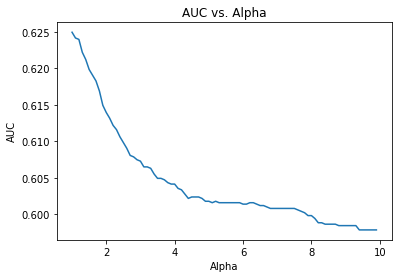

In [31]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [107]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true, prob_predicted_yval):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = prob_predicted_yval[:, 1]
    fpr0, tpr0, threshold0 = roc_curve(y_true, prob_predicted_yval[:, 0], pos_label=1)
    fpr1, tpr1, threshold1 = roc_curve(y_true, prob_predicted_yval[:, 1], pos_label=1)
    fpr2, tpr2, threshold2 = roc_curve(y_true, prob_predicted_yval[:, 2], pos_label=1)
    fpr3, tpr3, threshold3 = roc_curve(y_true, prob_predicted_yval[:, 3], pos_label=1)

    print("here")
    roc_auc = auc(fpr1, tpr1)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    # y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, probs)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr0, tpr0, 'b', label = 'AUC = %0.2f' % auc(fpr0, tpr0))
    plt.plot(fpr1, tpr1, 'g', label = 'AUC = %0.2f' % auc(fpr1, tpr1))
    plt.plot(fpr2, tpr2, 'r', label = 'AUC = %0.2f' % auc(fpr2, tpr2))
    plt.plot(fpr3, tpr3, 'c', label = 'AUC = %0.2f' % auc(fpr3, tpr3))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

here
AUC: 0.6984
Accuracy: 65.62%


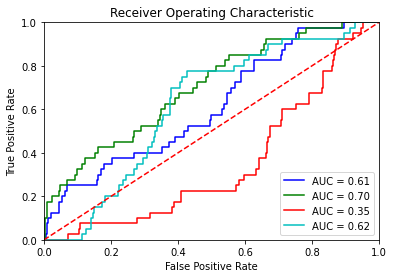

In [112]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1)

model.fit(X_train_tfidf, y_train)
prob_predicted_yval = model.predict_proba(X_val_tfidf)
predicted_yval = model.predict(X_val_tfidf)
#print(predicted_yval)
evaluate_roc(predicted_yval, y_val, prob_predicted_yval)




# print(predicted_yval[0])
# print(prob_predicted_yval[0])
# AUCplot(predicted_yval, y_val, prob_predicted_yval)

In [54]:
model.score(X_val_tfidf, y_val)

0.6562009419152276

### **Fine-tuning BERT**

In [53]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 14.8 MB/s 
     |████████████████████████████████| 6.5 MB 33.4 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Tokenization and Input Formatting**

In [57]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    text = re.sub(r'(#.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [58]:
# Print sentence 0
print('Original: ', X[3])
print('Processed: ', text_preprocessing(X[3]))

Original:  The lesson from Google One Pass: In this digital environment, users want to purchase across every platform with one tool. #sxsw #elonsxsw
Processed:  The lesson from Google One Pass: In this digital environment, users want to purchase across every platform with one tool. #elonsxsw


In [59]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [63]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.Product_Description.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  65


In [64]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Token IDs:  [101, 1996, 4773, 5859, 2226, 29653, 2015, 5009, 2000, 16380, 1006, 1998, 11924, 1007, 18726, 1010, 2651, 2184, 1037, 1012, 1049, 999, 1063, 4957, 1065, 1001, 1055, 2595, 26760, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

**Model Training**

In [70]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 40 µs, sys: 4 µs, total: 44 µs
Wall time: 47.7 µs


In [71]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [72]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [73]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.061760   |     -      |     -     |  341.03  
   1    |   40    |   0.926961   |     -      |     -     |  321.14  
   1    |   60    |   0.859062   |     -      |     -     |  323.61  
   1    |   80    |   0.786115   |     -      |     -     |  321.60  
   1    |   100   |   0.800955   |     -      |     -     |  329.72  
   1    |   120   |   0.784851   |     -      |     -     |  320.50  
   1    |   140   |   0.695361   |     -      |     -     |  318.67  
   1    |   159   |   0.698054   |     -      |     -     |  291.96  
----------------------------------------------------------------------
   1    |    -    |   0.828913   |  0.688697  |   69.70   |  2667.89 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [74]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [109]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc_bert(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr0, tpr0, threshold0 = roc_curve(y_true, probs[:, 0], pos_label=1)
    fpr1, tpr1, threshold1 = roc_curve(y_true, probs[:, 1], pos_label=1)
    fpr2, tpr2, threshold2 = roc_curve(y_true, probs[:, 2], pos_label=1)
    fpr3, tpr3, threshold3 = roc_curve(y_true, probs[:, 3], pos_label=1)

    print("here")
    roc_auc = auc(fpr1, tpr1)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    #y_pred = np.where(preds >= 0.5, 1, 0)
    y_pred = label(probs)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr0, tpr0, 'b', label = 'AUC = %0.2f' % auc(fpr0, tpr0))
    plt.plot(fpr1, tpr1, 'g', label = 'AUC = %0.2f' % auc(fpr1, tpr1))
    plt.plot(fpr2, tpr2, 'r', label = 'AUC = %0.2f' % auc(fpr2, tpr2))
    plt.plot(fpr3, tpr3, 'c', label = 'AUC = %0.2f' % auc(fpr3, tpr3))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [110]:
def label(probs):
  rs = []
  for p in probs:
    #print(p)
    max = -1
    index =-1
    for i in range(len(p)):
      if max < p[i]:
        max = p[i]
        index = i
    rs.append(index)
    # print(rs)
  return rs

**AUC and Accuracy**

[[0.0182062  0.03070466 0.3918409  0.5592482 ]
 [0.01182212 0.0055406  0.91008073 0.07255656]
 [0.01396403 0.00784361 0.67412394 0.30406845]
 ...
 [0.05545356 0.6606742  0.20250495 0.08136734]
 [0.01208066 0.00671721 0.92090625 0.06029586]
 [0.0458902  0.43193915 0.2778002  0.24437043]]
here
AUC: 0.9265
Accuracy: 72.06%


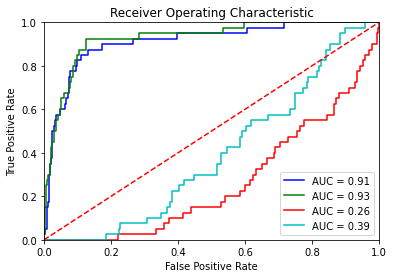

In [111]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)


print(probs)



# Evaluate the Bert classifier
evaluate_roc_bert(probs, y_val)

For the Baseline model the accuracy obtained is 65% and for the fine tuned bert classifier I was able to achieve a accuracy of 72%.